# Холодный старт

Данные - специально подготовленная выборка из полного набора, описанного здесь: https://mengtingwan.github.io/data/goodreads#datasets с дополнениями из https://www.kaggle.com/datasets/austinreese/goodreads-books:
- books: перечень книг (~44 тыс.) из списка https://www.goodreads.com/list/show/1.Best_Books_Ever (совпадение по book id),
- interactions: взаимодействие пользователей с книгами

Основной массив данных был собран в конце 2017.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import os

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

Создаём логгер, который удобен для использования в ноутбуке.

Загружаем данные как они есть, начинаем на них смотреть: какие в них есть сущности, атрибуты, распределения.

In [3]:
books = pd.read_parquet('books.parquet')

In [4]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43312 entries, 3 to 2360448
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   book_id               43312 non-null  int64  
 1   author                43312 non-null  object 
 2   title                 43312 non-null  object 
 3   description           43312 non-null  object 
 4   genre_and_votes       43312 non-null  object 
 5   num_pages             37001 non-null  Int64  
 6   average_rating        43312 non-null  float64
 7   ratings_count         43312 non-null  Int64  
 8   text_reviews_count    43312 non-null  int64  
 9   publisher             43312 non-null  object 
 10  publication_year      35891 non-null  Int64  
 11  country_code          43312 non-null  object 
 12  language_code         43312 non-null  object 
 13  format                43312 non-null  object 
 14  is_ebook              43312 non-null  bool   
 15  isbn                  

Пример данных по книгам

In [5]:
books[["book_id", "author", "title", "num_pages", "ratings_count", "ratings_count", "average_rating"]].sample\
    (5, random_state=52).sort_values("book_id").set_index("book_id")

,author,title,num_pages,ratings_count,ratings_count,average_rating
book_id,,,,,,
69882,"Heinrich Böll, Patrick Bowles",Billiards at Half-Past Nine,288,2005,2005,3.93
267533,Robert Cormier,8 Plus 1,173,250,250,3.67
820966,"Martin Luther, J.I. Packer, O.R. Johnston",The Bondage of the Will,322,5724,5724,4.17
4532622,Karen Hancock,The Enclave,492,426,426,3.82
20444381,Diana Gabaldon,Os tambores de outono - 1ª Parte (Outlander #4),1048,15,15,3.99


In [6]:
interactions = pd.read_parquet('interactions.parquet')

In [7]:
interactions.head(2)

,user_id,book_id,started_at,read_at,is_read,rating,is_reviewed
0,8842281e1d1347389f2ab93d60773d4d,22034,2015-07-12,2015-07-17,True,5,False
1,8842281e1d1347389f2ab93d60773d4d,22318578,2015-06-07,2015-08-09,True,5,True


Можно оценить объём данных о взаимодействиях

In [8]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12890434 entries, 0 to 12914458
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   book_id      int64 
 2   started_at   object
 3   read_at      object
 4   is_read      bool  
 5   rating       int64 
 6   is_reviewed  bool  
dtypes: bool(2), int64(2), object(3)
memory usage: 614.7+ MB


Пример данных по взаимодействиям

In [9]:
print(interactions[["user_id", "book_id", "started_at", "read_at", "is_read", "rating"]].sample(5, random_state=52).sort_values("user_id").set_index(["user_id", "book_id"]).to_string())

                                           started_at     read_at  is_read  rating
user_id                          book_id                                          
0447747f44c0d8d1a08cf329fe253f29 10054335  2016-04-08  2016-04-20     True       3
14432756ffba6357686f09e4ccc332bb 26252859  2016-05-27  2016-05-30     True       5
46d6c8cf548d1c86abb671f42ba71b5e 960       2014-08-06  2016-10-29     True       5
71c2b3714945af1f700f49953904c510 18492859  2014-10-09  2014-10-12     True       5
7802bafdeac8abff23a72b9dd60b1dd1 18710190  2015-03-01  2015-05-05     True       4


#### Задание. Проведите EDA представленного датасета. Оцените:

количество пользователей

In [10]:
n_users = interactions['user_id'].unique().shape[0]
n_users

542657

среднее количество прочитанных книг на пользователя

In [11]:
n_books_read = interactions[interactions["is_read"] == True].shape[0]
n_books_read

12890434

In [12]:
n_books_read / n_users

23.7542941489744

долю прочитанных книг, у которых нет рейтинга

In [13]:
n_read_norating = interactions[(interactions["is_read"] == True) & (interactions["rating"] == 0)].shape[0]
n_read_norating

1051672

In [14]:
n_read_norating / n_books_read

0.08158546097051503

распределение рейтинга

/home/ak/mle-recsys-start/.venv_recsys_py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ak/mle-recsys-start/.venv_recsys_py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ak/mle-recsys-start/.venv_recsys_py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


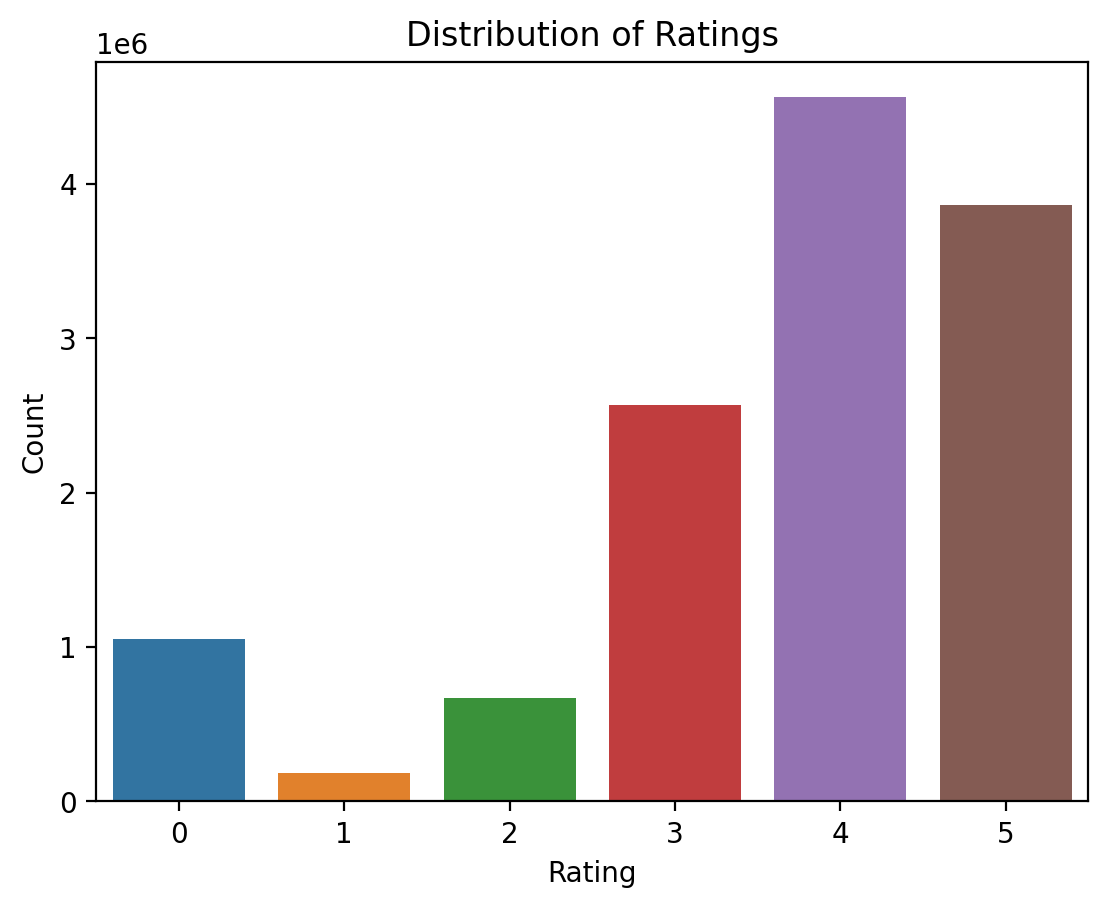

In [15]:
sns.countplot(x="rating", data=interactions)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [16]:
interactions["rating"].value_counts()

rating
4    4559434
5    3859840
3    2564629
0    1051672
2     671089
1     183770
Name: count, dtype: int64

Распределение популярности (долю пользователей, приходящуюся на одну книгу),

In [17]:
popularity_dist = interactions['book_id'].value_counts() / interactions.shape[0]
popularity_dist

book_id
22557272    3.506554e-03
11870085    3.431847e-03
11735983    2.534670e-03
13335037    2.385180e-03
9460487     2.357717e-03
                ...     
28175937    7.757691e-08
28364588    7.757691e-08
859858      7.757691e-08
28493748    7.757691e-08
848305      7.757691e-08
Name: count, Length: 41912, dtype: float64

#### Предварительная обработка данных (англ. preprocessing)

оставьте события только до 1 ноября 2017 года (не включительно) — событий позднее этой даты не должно быть в данных;

In [18]:
cutoff_value = datetime.date(2017, 11, 1)
cutoff_value

datetime.date(2017, 11, 1)

In [19]:
interactions = interactions[interactions["started_at"] < cutoff_value]

удалите события, для которых нет рейтинга;

In [20]:
interactions = interactions[interactions["rating"] != 0]

оставьте события только c признаком is_read=True;

In [21]:
interactions = interactions[interactions["is_read"] == True]

оставьте только тех пользователей, у которых две прочитанные книги и более.

In [22]:
user_count = interactions["user_id"].value_counts()
users_2more = user_count[user_count >= 2].index.to_list()

interactions = interactions[interactions["user_id"].isin(users_2more)]

Также переименуйте данные следующим образом (в пользу обобщённых названий):

In [23]:
items = books.copy()
del books

events = interactions.copy()
del interactions

In [24]:
items = items.rename(columns={"book_id": "item_id"})
events = events.rename(columns={"book_id": "item_id"})

А ещё для удобства перекодируйте идентификаторы пользователей из символьного вида (92f960b6da4be49c7955794c6331d759) в числовой. Все оставшиеся после обработки данных идентификаторы нужно отсортировать по возрастанию и последовательно пронумеровать, начиная с 1 000 000. Эти значения и будут новыми идентификаторами пользователей.

In [25]:
import pandas as pd

# Получение уникальных user_id и сортировка
unique_ids_sorted = sorted(events["user_id"].unique())

# Сопоставление строкового user_id с числовым идентификатором начиная с 1_000_000
user_id_map = {uid: new_id for new_id, uid in enumerate(unique_ids_sorted, start=1_000_000)}

# Добавление новой колонки с числовыми идентификаторами
events["user_id_new"] = events["user_id"].map(user_id_map)

In [26]:
events['user_id'] = events["user_id_new"]
events = events.drop('user_id_new', axis=1)

Сохраняем данные

In [27]:
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

Какая доля событий осталась после обработки данных?

In [28]:
events.shape[0] / pd.read_parquet("interactions.parquet").shape[0]

0.9117639483666725

## EDA

Посмотрим на данные о книгах, какие поля есть.

In [29]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2017-08-01").date()

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date

events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

common_users = list(set(users_train).intersection(set(users_test)))

print(len(users_train), len(users_test), len(common_users))

428284 123497 121099


Всего пользователей

In [30]:
events['user_id'].unique().shape

(430682,)

Идентифицируйте холодных пользователей и оцените их количество.

In [31]:
cold_users = users_test[~users_test.isin(users_train)]

print(len(cold_users))

2398


## Задание 4 из 6
Завершите код, чтобы получить топ-100 наиболее популярных книг согласно условиям выше.  Для этого найдите топ-100 наиболее популярных книг (учитывая и их среднюю оценку) за последние несколько лет. Например, с 2015 года и со средней оценкой не меньше 4.

In [32]:
# на основе events_train начиная с 2015-01-01
from sklearn.preprocessing import MinMaxScaler

top_pop_start_date = pd.to_datetime("2015-01-01").date()

item_popularity = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby(["item_id"]).agg(users=("user_id", "nunique"), avg_rating=("rating", "mean")).reset_index()

# нормализация пользователей и среднего рейтинга, требуется для их приведения к одному масштабу
scaler = MinMaxScaler()
item_popularity[["users_norm", "avg_rating_norm"]] = scaler.fit_transform(
    item_popularity[["users", "avg_rating"]]
)

# вычисляем popularity_score, как скор популярности со штрафом за низкий рейтинг
item_popularity["popularity_score"] = (
    item_popularity["users_norm"] * item_popularity["avg_rating_norm"]
)

# сортируем по убыванию popularity_score
item_popularity = item_popularity.sort_values(by="popularity_score", ascending=False)

# выбираем первые 100 айтемов со средней оценкой avg_rating не меньше 4
top_k_pop_items = item_popularity[item_popularity['avg_rating'] >= 4].iloc[:100, :]

top_k_pop_items

,item_id,users,avg_rating,users_norm,avg_rating_norm,popularity_score
32389,18007564,20208,4.321308,0.496547,0.830327,0.412297
32625,18143977,19464,4.290691,0.478265,0.822673,0.393456
2,3,15142,4.706049,0.372060,0.926512,0.344719
30697,16096824,16770,4.301014,0.412065,0.825253,0.340058
1916,15881,13043,4.632447,0.320482,0.908112,0.291033
...,...,...,...,...,...,...
24838,8490112,4792,4.080968,0.117729,0.770242,0.090680
33613,18966819,4362,4.374828,0.107163,0.843707,0.090414
378,3636,4667,4.098564,0.114658,0.774641,0.088819
32837,18293427,4674,4.092640,0.114830,0.773160,0.088782


Добавив информацию о книгах, можно просмотреть, какие попали в топ.

In [33]:
# добавляем информацию о книгах
top_k_pop_items = top_k_pop_items.merge(
    items.set_index("item_id")[["author", "title", "genre_and_votes", "publication_year"]], on="item_id")

with pd.option_context('display.max_rows', 100):
    display(top_k_pop_items[["item_id", "author", "title", "publication_year", "users", "avg_rating", "popularity_score", "genre_and_votes"]])

,item_id,author,title,publication_year,users,avg_rating,popularity_score,genre_and_votes
0,18007564,Andy Weir,The Martian,2014,20208,4.321308,0.412297,"{'Science Fiction': 11966, 'Fiction': 8430}"
1,18143977,Anthony Doerr,All the Light We Cannot See,2014,19464,4.290691,0.393456,"{'Historical-Historical Fiction': 13679, 'Fict..."
2,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,1997,15142,4.706049,0.344719,"{'Fantasy': 59818, 'Fiction': 17918, 'Young Ad..."
3,16096824,Sarah J. Maas,A Court of Thorns and Roses (A Court of Thorns...,2015,16770,4.301014,0.340058,"{'Fantasy': 14326, 'Young Adult': 4662, 'Roman..."
4,15881,"J.K. Rowling, Mary GrandPré",Harry Potter and the Chamber of Secrets (Harry...,1999,13043,4.632447,0.291033,"{'Fantasy': 50130, 'Young Adult': 15202, 'Fict..."
5,38447,Margaret Atwood,The Handmaid's Tale,1998,14611,4.232770,0.290151,"{'Fiction': 15424, 'Classics': 9937, 'Science ..."
6,11235712,Marissa Meyer,"Cinder (The Lunar Chronicles, #1)",2012,14349,4.179246,0.280230,"{'Young Adult': 10539, 'Fantasy': 9237, 'Scien..."
7,17927395,Sarah J. Maas,A Court of Mist and Fury (A Court of Thorns an...,2016,12179,4.730356,0.279078,"{'Fantasy': 10186, 'Romance': 3346, 'Young Adu..."
8,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Prisoner of Azkaban (Harr...,2004,11890,4.770143,0.275361,"{'Fantasy': 49784, 'Young Adult': 15393, 'Fict..."
9,13206900,Marissa Meyer,"Winter (The Lunar Chronicles, #4)",2015,12291,4.534293,0.266842,"{'Fantasy': 4835, 'Young Adult': 4672, 'Scienc..."


## Задание 5 из 6
Завершите предлагаемый код, чтобы в cold_users_events_with_recs для каждого события получить столбец avg_rating. В нём при совпадении по item_id будет значение из одноимённого столбца из top_k_pop_items, иначе — пропуск.
В cold_users_events_with_recs после выполнения завершённого кода должно быть столько же строк, сколько было до его выполнения.

In [34]:
# events_test (cold users) + avg_rating for books from 
cold_users_events_with_recs = \
    events_test[events_test["user_id"].isin(cold_users)] \
    .merge(top_k_pop_items.set_index("item_id")['avg_rating'], on="item_id", how="left")

# оставляем тех, где есть рейтинг
cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx] \
    [["user_id", "item_id", "rating", "avg_rating"]]

In [35]:
cold_users_events_with_recs

,user_id,item_id,started_at,read_at,is_read,rating,is_reviewed,avg_rating
0,1361691,6900,2017-10-09,2017-10-13,True,4,False,NaN
1,1361691,12555,2017-09-21,2017-10-11,True,3,False,NaN
2,1361691,25899336,2017-09-12,2017-09-17,True,4,True,4.427172
3,1361691,21936809,2017-08-20,2017-08-24,True,4,True,NaN
4,1361691,6952,2017-09-18,2017-09-20,True,3,False,NaN
...,...,...,...,...,...,...,...,...
9821,1178540,26599,2017-10-12,2017-11-01,True,4,False,NaN
9822,1253215,51113,2017-09-25,2017-10-07,True,4,False,NaN
9823,1253215,16181775,2017-09-24,2017-09-25,True,3,False,NaN
9824,1253215,10210,2017-09-16,2017-09-24,True,5,False,NaN


Для какой доли событий «холодных» пользователей в events_test рекомендации в top_k_pop_items совпали по книгам? Округлите ответ до сотых.

In [36]:
cold_user_recs.shape[0] / cold_users_events_with_recs.shape[0]

0.19651943822511703

## Задание 6
Посчитайте метрики rmse и mae для полученных рекомендаций.

In [37]:
# посчитаем метрики рекомендаций
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(cold_user_recs["rating"], cold_user_recs["avg_rating"])
mae = mean_absolute_error(cold_user_recs["rating"], cold_user_recs["avg_rating"])
print(round(rmse, 2), round(mae, 2))

0.6 0.62


посчитаем покрытие холодных пользователей рекомендациями

In [38]:
# посчитаем покрытие холодных пользователей рекомендациями

cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля пользователей без релевантных рекомендаций: 0.59
Среднее покрытие пользователей: 0.44


# Матрица взаимодействий и первые персональные рекомендации

Оцените степень разреженности U-I-матрицы, построенной на основе events. Используйте формулу выше и данные events[['user_id', 'item_id', 'rating']]. Какое значение корректно описывает результат?

In [39]:
all_cells = np.unique(events['user_id']).shape[0] * np.unique(events['item_id']).shape[0]
filled_cells = events.shape[0]
empty_cells = all_cells - filled_cells
empty_cells / all_cells

0.9993451864978748

#### Реализация SVD-алгоритма
Воспользуемся готовой реализацией SVD-алгоритма из библиотеки surprise. В качестве разбиения данных на train и test возьмём разбиение из предыдущего урока: events_train, events_test.

In [40]:
# !pip install numpy==1.26.0 --no-cache-dir
# !pip install scikit-surprise

In [41]:
from surprise import Dataset, Reader
from surprise import SVD

In [42]:
# используем Reader из библиотеки surprise для преобразования событий (events)
# в формат, необходимый surprise
reader = Reader(rating_scale=(1, 5))
surprise_train_set = Dataset.load_from_df(events_train[['user_id', 'item_id', 'rating']], reader)
surprise_train_set = surprise_train_set.build_full_trainset()

# инициализируем модель
svd_model = SVD(n_factors=100, random_state=0)

# обучаем модель
svd_model.fit(surprise_train_set)

рекомендации для тестовой выборки

In [43]:
surprise_test_set = list(events_test[['user_id', 'item_id', 'rating']].itertuples(index=False))
 
# получаем рекомендации для тестовой выборки
svd_predictions = svd_model.test(surprise_test_set)

In [44]:
events_test[['user_id', 'item_id', 'rating']].shape

(426501, 3)

In [45]:
len(svd_predictions)

426501

Полученные рекомендации можно оценить, используя встроенный модуль accuracy из библиотеки surprise:

In [46]:
from surprise import accuracy

rmse = accuracy.rmse(svd_predictions)
mae = accuracy.mae(svd_predictions)

print(rmse, mae)

RMSE: 0.8283
MAE:  0.6470
0.8282819066345143 0.6470339923925352


Понять, хороши или плохи полученные значения метрик, поможет проверка на адекватность (англ. sanity check). Например, сравним качество рекомендаций со случайными по тем же метрикам.

In [47]:
from surprise import NormalPredictor

# инициализируем состояние генератора, это необходимо для получения
# одной и той же последовательности случайных чисел, только в учебных целях
np.random.seed(0)

random_model = NormalPredictor()

random_model.fit(surprise_train_set)
random_predictions = random_model.test(surprise_test_set)

Рассчитайте значение MAE для random_predictions. Округлите его до сотых.
На сколько процентов MAE для случайных рекомендаций от NormalPredictor выше значения MAE от SVD? Ответ округлите до десятых.

In [48]:
rmse = accuracy.rmse(random_predictions)
mae = accuracy.mae(random_predictions)

print(rmse, mae)

RMSE: 1.2607
MAE:  1.0000
1.2607087191186703 1.0000499000278655


In [49]:
1.0000 / 0.6470 * 100 # 54 процента

154.55950540958267

Создайте функцию, которая позволит получить рекомендации для конкретного пользователя, используя описанный подход. Дополните прекод.

In [50]:
def get_recommendations_svd(user_id, all_items, events, model, include_seen=True, n=5):

    """ возвращает n рекомендаций для user_id """

    # получим список идентификаторов всех книг
    all_items = set(events['item_id'].unique())

    # учитываем флаг, стоит ли уже прочитанные книги включать в рекомендации
    if include_seen:
        items_to_predict = list(all_items)
    else:
        # получим список книг, которые пользователь уже прочитал ("видел")
        seen_items = set(events[~events['item_id'].isna()]['item_id'].unique())

        # книги, которые пользователь ещё не читал
        # только их и будем включать в рекомендации
        items_to_predict = list(all_items - seen_items)

    # получаем скоры для списка книг, т. е. рекомендации
    predictions = [model.predict(user_id, item_id) for item_id in items_to_predict]

    # сортируем рекомендации по убыванию скора и берём только n первых
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    return pd.DataFrame([(pred.iid, pred.est) for pred in recommendations], columns=["item_id", "score"])

In [51]:
get_recommendations_svd(1296647, items, events, svd_model, include_seen=True, n=5)

,item_id,score
0,17874649,5.000000
1,2939264,5.000000
2,11221285,5.000000
3,30688013,4.974140
4,6147461,4.947472


Некоторые проблемы рекомендаций отследить с помощью метрик сложно. Например, с помощью метрик сложно выявить рекомендации с низким разнообразием — когда пользователю, который прочитал книгу одного автора, рекомендуются книги преимущественно того же автора. Такие проблемы проще отследить «глазами».
Для этого нужно вывести последние события для случайного пользователя и рекомендации для него. Это можно сделать с помощью функции get_recommendations_svd:

In [52]:
# выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id = events_train['user_id'].sample().iat[0]

print(f"user_id: {user_id}")

print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("item_id")[["author", "title", "genre_and_votes"]], on="item_id")
)
user_history_to_print = user_history[["author", "title", "started_at", "read_at", "rating", "genre_and_votes"]].tail(10)
display(user_history_to_print)

print("Рекомендации")
user_recommendations = get_recommendations_svd(user_id, items, events_train, svd_model)
user_recommendations = user_recommendations.merge(items[["item_id", "author", "title", "genre_and_votes"]], on="item_id")
display(user_recommendations)

user_id: 1107777
История (последние события, recent)


,author,title,started_at,read_at,rating,genre_and_votes
60,Lois Lowry,"Son (The Giver, #4)",2015-01-02,2015-01-07,2,"{'Young Adult': 1553, 'Science Fiction-Dystopi..."
61,Lois Lowry,"Messenger (The Giver, #3)",2014-12-21,2014-12-22,4,"{'Young Adult': 2020, 'Science Fiction-Dystopi..."
62,Rachel Joyce,The Unlikely Pilgrimage of Harold Fry (Harold ...,2016-10-24,2016-10-29,5,"{'Fiction': 2552, 'Contemporary': 492}"
63,Gabrielle Zevin,The Storied Life of A.J. Fikry,2016-10-22,2016-10-23,5,"{'Fiction': 3795, 'Contemporary': 1100, 'Writi..."
64,James Dashner,"The Kill Order (Maze Runner, #0.5)",2016-07-12,2016-07-14,1,"{'Young Adult': 1715, 'Science Fiction-Dystopi..."
65,Geraldine Brooks,People of the Book,2016-10-14,2016-10-22,5,"{'Historical-Historical Fiction': 2644, 'Ficti..."
66,Robert Galbraith,"The Silkworm (Cormoran Strike, #2)",2014-12-21,2014-12-28,5,"{'Mystery': 4585, 'Fiction': 2232, 'Mystery-Cr..."
67,Robert Galbraith,"The Cuckoo's Calling (Cormoran Strike, #1)",2014-12-12,2014-12-17,5,"{'Mystery': 7357, 'Fiction': 3947, 'Mystery-Cr..."
68,Kate Morton,The Secret Keeper,2016-10-10,2016-10-14,5,"{'Historical-Historical Fiction': 1861, 'Ficti..."
69,Kate Morton,The Lake House,2016-08-27,2016-08-29,4,"{'Historical-Historical Fiction': 1239, 'Ficti..."


Рекомендации


,item_id,score,author,title,genre_and_votes
0,17332218,4.856496,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)","{'Fantasy': 8542, 'Fiction': 872, 'Fantasy-Epi..."
1,136251,4.814140,J.K. Rowling,Harry Potter and the Deathly Hallows (Harry Po...,"{'Fantasy': 46667, 'Young Adult': 15403, 'Fict..."
2,29237211,4.809071,"Brian K. Vaughan, Fiona Staples","Saga, Vol. 7 (Saga, #7)","{'Sequential Art-Graphic Novels': 2539, 'Seque..."
3,1,4.800504,J.K. Rowling,Harry Potter and the Half-Blood Prince (Harry ...,"{'Fantasy': 46400, 'Young Adult': 15083, 'Fict..."
4,22037424,4.793632,"J.K. Rowling, Jonny Duddle, Tomislav Tomić",Harry Potter and the Prisoner of Azkaban (Harr...,"{'Fantasy': 49994, 'Young Adult': 15433, 'Fict..."


# Коллаборативная фильтрация: ALS

In [53]:
import scipy
import sklearn.preprocessing

# перекодируем идентификаторы пользователей:
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы объектов:
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

/tmp/ipykernel_409/1826093835.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_409/1826093835.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
/tmp/ipykernel_409/1826093835.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Сохраним events_train и events_test

In [54]:
os.makedirs('intermediate_data', exist_ok=True)

In [55]:
events_train.to_parquet("intermediate_data/events_train.parquet")
events_test.to_parquet("intermediate_data/events_test.parquet")

Какое максимальное значение получилось для events_train[’item_id_enc']?

In [56]:
events_train['item_id_enc'].max()

43304

Вычислите размер матрицы user_item_matrix_train, как если бы она хранила все свои элементы, включая пропуски, и для каждого элемента использовался бы один байт.

In [57]:
(events_train['item_id_enc'].unique().shape[0] * events_train['user_id_enc'].unique().shape[0]) / (1024 ** 3)

16.543156374245882

Sparce матрица для взаимодействий на основе events_train

In [58]:
# создаём sparse-матрицу формата CSR
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["rating"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

In [59]:
user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 11326532 stored elements and shape (430682, 43305)>

In [60]:
import sys

sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3

0.2637163735926151

Имея подготовленную матрицу взаимодействий, перейдём к третьему шагу — создадим ALS-модель. Для примера возьмём количество латентных факторов для матриц $P, Q$, равным 50.

In [61]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

/home/ak/mle-recsys-start/.venv_recsys_py310/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

Чтобы получить рекомендации для пользователя с помощью модели ALS, используем такую функцию:

In [62]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc,
         user_item_matrix[user_id_enc],
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])

    return recommendations

Получим рекомендации для всех имеющихся пользователей. Выполните код ниже.

In [63]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_train[user_ids_encoded],
    filter_already_liked_items=False, N=100)

In [64]:
events_train['user_id_enc'].unique().shape, events_test['user_id_enc'].unique().shape

((428284,), (123497,))

In [65]:
user_item_matrix_train.shape

(430682, 43305)

In [66]:
als_recommendations[0].shape, als_recommendations[1].shape

((430682, 100), (430682, 100))

In [67]:
als_recommendations

(array([[    2,  1942,     3, ..., 41514,     7, 22360],
        [31432, 29792, 36956, ..., 41514, 31520,  1043],
        [33276, 37255, 35810, ...,  1043, 23845, 42047],
        ...,
        [20997, 20386, 23004, ..., 11665, 28844, 29720],
        [22844, 37138, 28025, ..., 35853,   532,  4112],
        [34434, 33783, 35669, ..., 41963, 27352, 39056]], dtype=int32),
 array([[0.976627  , 0.88614887, 0.8577641 , ..., 0.22714944, 0.22655179,
         0.22626536],
        [0.671054  , 0.62364125, 0.48714206, ..., 0.02283462, 0.02274973,
         0.02266375],
        [0.23131761, 0.18923154, 0.17818768, ..., 0.04601035, 0.04447012,
         0.04419186],
        ...,
        [0.23330341, 0.23172742, 0.22057155, ..., 0.02847586, 0.02846107,
         0.02821758],
        [0.0547352 , 0.03821368, 0.03751416, ..., 0.01520865, 0.01504071,
         0.01504055],
        [0.4470645 , 0.4368139 , 0.436614  , ..., 0.09779324, 0.09638054,
         0.09628507]], dtype=float32))

Код возвращает рекомендации как список списков, это не очень удобно. Преобразуем его в более удобный формат — табличный.

In [68]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(),
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

Сохраним полученные рекомендации в файл, они ещё нам пригодятся.

In [69]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("als_recommendations.parquet") 

## Метрики

In [70]:
als_recommendations = (
    als_recommendations
    .merge(events_test[["user_id", "item_id", "rating"]]
               .rename(columns={"rating": "rating_test"}),
           on=["user_id", "item_id"], how="left")
)

In [71]:
als_recommendations[(als_recommendations["rating_test"].notna()) & (als_recommendations["user_id"] == 1000006)]

,user_id,item_id,score,rating_test
612,1000006,18774964,0.331588,4.0
615,1000006,29868610,0.288771,4.0
634,1000006,7445,0.219649,4.0
650,1000006,18812405,0.175393,3.0
676,1000006,24817626,0.149680,3.0


# Подсчитать метрику NDCG для одного пользователя поможет готовая реализация из scikit-learn:

In [72]:
import sklearn.metrics

def compute_ndcg(rating: pd.Series, score: pd.Series, k):

    """ подсчёт ndcg
    rating: истинные оценки
    score: оценки модели
    k: количество айтемов (по убыванию score) для оценки, остальные - отбрасываются
    """
    
    # если кол-во объектов меньше 2, то NDCG - не определена
    if len(rating) < 2:
        return np.nan

    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)

    return ndcg

Умея считать NDCG для одного пользователя, посчитаем данную метрику, например, для 
k
5
k=5 для всех пользователей из тестовой выборки. В результате каждому пользователю будет соответствовать одно значение NDCG@5. Запись “NDCG@5” означает, что метрика NDCG считается для пяти объектов. 

In [73]:
als_recommendations[als_recommendations["rating_test"].notna()]

,user_id,item_id,score,rating_test
612,1000006,18774964,0.331588,4.0
615,1000006,29868610,0.288771,4.0
634,1000006,7445,0.219649,4.0
650,1000006,18812405,0.175393,3.0
676,1000006,24817626,0.149680,3.0
...,...,...,...,...
43066677,1430666,28763485,0.232897,5.0
43067071,1430670,1618,0.108422,4.0
43067558,1430675,17061,0.643452,5.0
43067572,1430675,830502,0.572333,5.0


In [74]:
rating_test_idx = ~als_recommendations["rating_test"].isnull()
ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["score"], k=5))

In [75]:
ndcg_at_5_scores[ndcg_at_5_scores.notna()].shape

(17294,)

Рекомендуем 100 книг для каждого пользователя, могут быть несовппадения, если мерджим по user_id, item_id, пользователь мог не читать ни одной из этих 100 книг

In [76]:
events_test["user_id"].unique().shape

(123497,)

In [77]:
round(ndcg_at_5_scores.mean(), 2)

0.98

In [78]:
17294 / 123497

0.14003579034308525

# Контентные рекомендации

## Составим список всех жанров

Сначала преобразуем значения в genre_and_votes из текстового представления в тип в Python:

In [79]:
items["genre_and_votes"] = items["genre_and_votes"].apply(eval)

## Задание 1 из 4
Теперь составьте список жанров с долями голосов по ним в genres.  Дополните и выполните следующий код:

In [80]:
def get_genres(items):

    """ 
    извлекает список жанров по всем книгам, 
    подсчитывает долю голосов по каждому их них
    """
    
    genres_counter = {}
    
    for k, v, in items.iterrows():
        genre_and_votes = v["genre_and_votes"]
        if genre_and_votes is None or not isinstance(genre_and_votes, dict):
            continue
        for genre, votes in genre_and_votes.items():
            # увеличиваем счётчик жанров
            try:
                genres_counter[genre] += votes
            except KeyError:
                genres_counter[genre] = 0

    genres = pd.Series(genres_counter, name="votes")
    genres = genres.to_frame()
    genres = genres.reset_index().rename(columns={"index": "name"})
    genres.index.name = "genre_id"
    
    return genres
   
genres = get_genres(items)

Результат выполнения кода — список жанров с долями голосов по ним в genres. Посмотрим на самые популярные жанры:

In [81]:
genres["score"] = genres["votes"] / genres["votes"].sum()
genres.sort_values(by="score", ascending=False).head(10)

,name,votes,score
genre_id,,,
25,Fantasy,6850060,0.149651
1,Fiction,6406256,0.139955
38,Classics,3414934,0.074605
18,Young Adult,3296951,0.072027
34,Romance,2422614,0.052926
5,Nonfiction,1737406,0.037957
16,Historical-Historical Fiction,1531205,0.033452
20,Mystery,1371196,0.029956
24,Science Fiction,1218917,0.026629


In [82]:
genres.to_parquet("intermediate_data/genres.parquet")

## Подготовим матрицы
## Задание 2 из 4

Матрица книга - жанр. Сколько человек проголосовало за каждый жанр (норрмализация в сумме 1)

In [83]:
def get_item2genre_matrix(genres, items):

    # словарь жанр - id жанра
    genre_names_to_id = genres.reset_index().set_index("name")["genre_id"].to_dict()
    
    # list to build CSR matrix
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []

    # проходимся по строкам айтемов (книг)
    for item_idx, (k, v) in enumerate(items.iterrows()):
        if v["genre_and_votes"] is None:
            continue
        # проходимся по жанрам и голосам в строке айтемов (сколько людей проголосовало за тот или иной жанр)
        for genre_name, votes in v["genre_and_votes"].items():
            genre_idx = genre_names_to_id[genre_name] # определяем id жанра из словаря
            genres_csr_data.append(int(votes)) # голоса
            genres_csr_row_idx.append(item_idx) # порядковый номер айтема
            genres_csr_col_idx.append(genre_idx) # id айтема

    genres_csr = scipy.sparse.csr_matrix((genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)), shape=(len(items), len(genres)))
    # нормализуем, чтобы сумма оценок принадлежности к жанру была равна 1
    genres_csr = sklearn.preprocessing.normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr 

Получим матрицу с весами по жанрам для каждой книги: Это важный результат. Он поможет вычислить, какие книги «ближе» к пользовательскому вектору.

In [84]:
items = items.sort_values(by="item_id_enc")
all_items_genres_csr = get_item2genre_matrix(genres, items)

In [84]:
all_items_genres_csr.shape

(43312, 815)

Аналогичным образом получим матрицу с весами по жанрам для какого-нибудь пользователя, например, для пользователя с идентификатором 1000010. 

In [85]:
# То же самое что и выше только для айтемов пользователя
user_id = 1000010
user_events = events_train.query("user_id == @user_id")[["item_id", "rating"]]
user_items = items[items["item_id"].isin(user_events["item_id"])]

user_items_genres_csr = get_item2genre_matrix(genres, user_items)
user_items_genres_csr

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 149 stored elements and shape (22, 815)>

In [86]:
user_items_genres_csr.count_nonzero()

149

На практике часто пользователь явно указывает предпочтения в своём профиле. У нас таких данных нет, поэтому предпочтения пользователя по жанрам вычислим автоматически на основе его истории поведения. среднее взвешенное значение популяции на его оценки книг. !!!

In [87]:
# вычислим склонность пользователя к жанрам как среднее взвешенное значение популяции на его оценки книг.

# преобразуем пользовательские оценки из списка в вектор-столбец
user_ratings = user_events["rating"].to_numpy() / 5
user_ratings = np.expand_dims(user_ratings, axis=1) # преобразуем в столбец ([n, 1])

user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings) # - поэлементное умножение,

user_genres_scores = np.asarray(user_items_genres_weighted.mean(axis=0))

In [88]:
user_ratings.shape

(22, 1)

In [89]:
user_items_genres_weighted.shape

(22, 815)

In [90]:
user_genres_scores.shape

(1, 815)

Можно посмотреть, какие жанры больше всего нравятся пользователю:

In [91]:
# выведем список жанров, которые предпочитает пользователь

user_genres = genres.copy()
user_genres["score"] = np.ravel(user_genres_scores)
user_genres = user_genres[user_genres["score"] > 0].sort_values(by=["score"], ascending=False)

user_genres.head(5)

,name,votes,score
genre_id,,,
1,Fiction,6406256,0.185241
38,Classics,3414934,0.103879
25,Fantasy,6850060,0.072447
5,Nonfiction,1737406,0.050865
24,Science Fiction,1218917,0.040920


In [92]:
all_items_genres_csr.shape, user_genres_scores.shape

((43312, 815), (1, 815))

## Задание 4 из 4
Получите наиболее релевантные рекомендации для пользователя. Дополните код так, чтобы переменная top_k_indices заполнялась индексами соответствующих книг. Для этого удобно использовать np.argsort от similarity_scores, подсчитанной для всех книг.
После вычисления top_k_indices по полученным индексам извлеките список объектов, которые могут быть интересны пользователю, при помощи кода:

In [93]:
from sklearn.metrics.pairwise import cosine_similarity

# вычисляем сходство между вектором пользователя и векторами по книгам
similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores)

# преобразуем в одномерный массив
similarity_scores = similarity_scores.flatten()

# получаем индексы top-k (по убыванию значений), по сути, индексы книг (encoded)
k = 5
top_k_indices = np.argsort(similarity_scores)[:k]

In [94]:
all_items_genres_csr

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 210895 stored elements and shape (43312, 815)>

In [95]:
items.iloc[top_k_indices, :]

,item_id,author,title,description,genre_and_votes,num_pages,average_rating,ratings_count,text_reviews_count,publisher,publication_year,country_code,language_code,format,is_ebook,isbn,isbn13,genre_and_votes_dict,genre_and_votes_str,item_id_enc
956516,22547731,"Tina Marie Kaht, Valeria Avantario",Grandparents' Day,"In this heartwarming story, a loving grandchil...",{'Childrens': 2},34,4.38,8,6,Createspace Independent Publishing Platform,2014,US,,Paperback,False,1500109673,9781500109677,"{'Academic': None, 'Academic-Academia': None, ...",Childrens 2,38862
515584,22523971,Nayyirah Waheed,Nejma,,"{'Poetry': 929, 'Feminism': 31}",178,4.06,1967,213,CreateSpace Independent Publishing Platform,2014,US,en-CA,Paperback,False,1494493322,9781494493325,"{'Academic': None, 'Academic-Academia': None, ...","Poetry 929, Feminism 31",38838
1673075,197515,Mo Willems,"Today I Will Fly! (Elephant & Piggie, #1)",Gerald is careful. Piggie is not.\nPiggie cann...,"{'Childrens-Picture Books': 409, 'Childrens': ...",57,4.30,10612,388,Hyperion Books for Children,2007,US,eng,Hardcover,False,1423102959,9781423102953,"{'Academic': None, 'Academic-Academia': None, ...","Childrens-Picture Books 409, Childrens 199",9716
1422146,1504506,Nicholas Davies,Diana the Killing of a Princess,"When Diana, Princess of Wales, died in a horri...",None,300,2.50,4,1,New Generation Publishing,2006,US,,Paperback,False,1905621485,9781905621484,None,None,18969
1523576,1481056,Lester Sumrall,Gifts and Ministries of the Holy Spirit,The gifts of the Spirit can destroy any force ...,"{'Christian': 6, 'Religion-Theology': 3, 'Chri...",<NA>,4.43,178,14,Whitaker Distribution,2005,US,eng,Paperback,False,088368652X,9780883686522,"{'Academic': None, 'Academic-Academia': None, ...","Christian 6, Religion-Theology 3, Christian-Ch...",18925


# Валидация

## Метрики классификации («попадания»)

In [96]:
als_recommendations

,user_id,item_id,score,rating_test
0,1000000,3,0.976627,NaN
1,1000000,15881,0.886149,NaN
2,1000000,5,0.857764,NaN
3,1000000,6,0.825622,NaN
4,1000000,2,0.781237,NaN
...,...,...,...,...
43068195,1430681,6900,0.098617,NaN
43068196,1430681,25574782,0.098023,NaN
43068197,1430681,29610595,0.097793,NaN
43068198,1430681,8949352,0.096381,NaN


Посчитаем recall и precision для ALS-рекомендаций (als_recommendations). Для этого события в тестовой выборке и рекомендации для одних и тех же пользователей разметим признаками:
gt (ground truth): объект есть в тестовой выборке;
pr (predicted): объект есть в рекомендациях.
Теперь разметим признаки бинарной классификации:
TP: объект есть и в тестовой выборке, и в рекомендациях (истинная рекомендация),
FP: объекта нет в тестовой выборке, но он есть в рекомендациях (ложноположительная рекомендация),
FN: объект есть в тестовой выборке, но его нет в рекомендациях (ложноотрицательная рекомендация)

In [97]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]
 
    return events_recs_common

In [98]:
events_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    als_recommendations, 
    top_k=5)

/tmp/ipykernel_2135/119025985.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 123497


In [99]:
events_recs_for_binary_metrics

,user_id,item_id,gt,score,pr,tp,fp,fn
0,1196679,18467802,True,NaN,False,False,False,True
1,1188780,10799,True,NaN,False,False,False,True
2,1001879,13206828,True,NaN,False,False,False,True
3,1001879,13206900,True,NaN,False,False,False,True
4,1001879,13206760,True,NaN,False,False,False,True
...,...,...,...,...,...,...,...,...
1033001,1430681,17167166,False,0.447064,True,False,True,False
1033002,1430681,16096824,False,0.436814,True,False,True,False
1033003,1430681,17927395,False,0.436614,True,False,True,False
1033004,1430681,29056083,False,0.431703,True,False,True,False


## Задание
Дополните код функции compute_cls_metrics для расчёта recall. Получите значения метрик precision@5, recall@5.

In [100]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [101]:
compute_cls_metrics(events_recs_for_binary_metrics) 

(0.007629335125549608, 0.014047805206454458)

# Сецифичные метрики

## Задание 1 из 2. посчитайте покрытие по объектам согласно формуле

Для рекомендаций, сохранённых в переменной als_recommendations, посчитайте покрытие по объектам согласно формуле выше. При этом используйте весь топ-100 рекомендаций.

In [102]:
als_recommendations["item_id"].unique().shape[0] / items["item_id"].unique().shape[0]

0.09341521980051717

In [103]:
items["item_id"].unique().shape

(43312,)

## Задание 2 из 2. Посчитайте среднее Novelty@5 для als_recommendations

In [104]:
events_train

,user_id,item_id,started_at,read_at,is_read,rating,is_reviewed,user_id_enc,item_id_enc
0,1229180,22034,2015-07-12,2015-07-17,True,5,False,229180,2460
1,1229180,22318578,2015-06-07,2015-08-09,True,5,True,229180,38691
2,1229180,22551730,2015-06-24,2015-07-11,True,4,True,229180,38867
3,1229180,22816087,2015-09-27,2015-11-04,True,5,True,229180,39109
5,1229180,17910054,2015-03-04,2015-07-28,True,3,False,229180,35638
...,...,...,...,...,...,...,...,...,...
12914452,1364554,5297,2017-02-07,2017-02-26,True,5,False,364554,597
12914453,1364554,4900,2016-12-22,2016-12-29,True,2,False,364554,517
12914454,1364554,14836,2016-11-29,2017-01-15,True,3,False,364554,1828
12914456,1297089,10210,2012-06-05,2013-01-17,True,5,False,297089,1196


In [105]:
# разметим каждую рекомендацию признаком read
events_train["read"] = True
als_recommendations = als_recommendations.merge(events_train[["user_id", "item_id", "read"]], on=["user_id", "item_id"], how="left")
als_recommendations["read"] = als_recommendations["read"].fillna(False).astype("bool")

# проставим ранги
als_recommendations = als_recommendations.sort_values(by=["user_id", "score"], ascending=False)
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1-als_recommendations.query("rank <= 5").groupby("user_id")["read"].mean())

# посчитаем средний novelty
novelty_5.mean()

/tmp/ipykernel_2135/2769298883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["read"] = True


0.6070102767238936

# Двухстадийный подход

## Задание 1 из 6

In [89]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

In [90]:
events_train = pd.read_parquet("intermediate_data/events_train.parquet")
events_test = pd.read_parquet("intermediate_data/events_test.parquet")

In [91]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2017-09-15").date()

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

Сколько уникальных пользователей есть в events_labels?

In [92]:
events_labels["user_id"].unique().shape

(99915,)

## Задание 2 из 6. Объедините имеющихся кандидатов по совпадению user_id, item_id в один список.

In [ ]:
# загружаем рекомендации от двух базовых генераторов
als_recommendations = pd.read_parquet("candidates/training/als_recommendations.parquet")
content_recommendations = pd.read_parquet("candidates/training/content_recommendations.parquet")

candidates = pd.merge(
    als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    content_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "cnt_score"}),
    on=["user_id", "item_id"],
    how="outer")

In [ ]:
candidates.shape

In [ ]:
del als_recommendations
del content_recommendations

## Задание 3 из 6

В candidates добавьте колонку target со значениями:
1 для тех item_id, которые пользователь прочитал (положительный пример).
0 — для всех остальных (негативный пример).
В candidates_for_train отберите все положительные примеры, а также не менее четырёх негативных примеров для каждого пользователя в положительных примерах.

In [ ]:
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прочитал
# — 0, для всех остальных 

events_labels["target"] = 1
candidates = candidates.merge(events_labels[["user_id", "item_id", "target"]], 
                              on=["user_id", "item_id"], how="left")
candidates["target"] = candidates["target"].fillna(0).astype("int")

# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ])

In [ ]:
del candidates

Обучение модели

In [ ]:
from catboost import CatBoostClassifier, Pool

# задаём имена колонок признаков и таргета
features = ['als_score', 'cnt_score']
target = 'target'

# Create the Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
cb_model.fit(train_data, plot=True)

In [ ]:
del train_data

## Задание 4 из 6

In [ ]:
# загружаем рекомендации от двух базовых генераторов
als_recommendations_2 = pd.read_parquet("candidates/inference/als_recommendations.parquet")
content_recommendations_2 = pd.read_parquet("candidates/inference/content_recommendations.parquet")

In [ ]:
candidates_to_rank = pd.merge(
    als_recommendations_2[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    content_recommendations_2[["user_id", "item_id", "score"]].rename(columns={"score": "cnt_score"}),
    on=["user_id", "item_id"],
    how="outer")

# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = candidates_to_rank[candidates_to_rank["user_id"].isin(events_test_2["user_id"].drop_duplicates())]
print(len(candidates_to_rank))

## Задание 5 из 6

In [ ]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
# Проставляем ранги для каждого user_id, начиная с 1 (наивысший cb_score)
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

# Оставляем только топ-N рекомендаций на каждого пользователя
max_recommendations_per_user = 100
final_recommendations = candidates_to_rank[candidates_to_rank["rank"] <= max_recommendations_per_user]

In [ ]:
final_recommendations.shape

## Задание 6 из 6

In [ ]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]
 
    return events_recs_common

def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

Посчитайте метрики recall и precision.
Используйте полученные рекомендации final_recommendations, отложенную тестовую выборку events_test_2, созданные в уроке «Валидация» предыдущей темы.
А также функции process_events_recs_for_binary_metrics и compute_cls_metrics.

In [ ]:
events_inference = pd.concat([events_train, events_labels])

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

# Как использовать признаки для улучшения рекомендаций

## Задание 1 из 6. Признаки объектов

In [ ]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

In [ ]:
items = pd.read_parquet("items.parquet")

In [ ]:
items["age"] = 2018 - items["publication_year"]
invalid_age_idx = items["age"] < 0
items.loc[invalid_age_idx, "age"] = np.nan
items["age"] = items["age"].astype("float")

candidates_for_train = candidates_for_train.merge(items[["item_id", "age", "average_rating"]], on="item_id", how="left")
candidates_to_rank = candidates_to_rank.merge(items[["item_id", "age", "average_rating"]], on="item_id", how="left")

In [ ]:
candidates_to_rank["age"].median()

## Задание 2 из 6. Признаки пользователей

In [ ]:
def get_user_features(events):
    """Считает пользовательские признаки"""
    
    user_features = events.groupby("user_id").agg(
        reading_years=("started_at", lambda x: (x.max() - x.min()).days / 365.25),
        books_read=("item_id", "nunique"),  # количество уникальных книг
        rating_avg=("rating", "mean"),
        rating_std=("rating", "std")
    )
    
    user_features["books_per_year"] = user_features["books_read"] / user_features["reading_years"]
    
    return user_features


# Вычисление признаков для тренировочной выборки
user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")

# Подготовка событий для инференса
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test["user_id"].drop_duplicates())]

# Вычисление признаков для ранжирования (инференса)
user_features_for_ranking = get_user_features(events_inference)
candidates_to_rank = candidates_to_rank.merge(user_features_for_ranking, on="user_id", how="left")

In [ ]:
candidates_to_rank

In [ ]:
candidates_to_rank["books_read"].median()

## Задание 3 из 6. Парные признаки

In [ ]:
genres = pd.read_parquet("intermediate_data/genres.parquet")

In [ ]:
# Определяем индексы топ-10 жанров и всех остальных
genres_top_k = 10
genres_top_idx = genres.sort_values("votes", ascending=False).head(genres_top_k).index
genres_others_idx = list(set(genres.index) - set(genres_top_idx))

# Формируем названия колонок для жанров
genres_top_columns = [f"genre_{id}" for id in genres_top_idx]
genres_others_column = "genre_others"
genre_columns = genres_top_columns + [genres_others_column]

# Составляем таблицу принадлежности книг к жанрам (жанровые веса для каждой книги)
item_genres = (
    pd.concat([
        # топ жанров
        pd.DataFrame(all_items_genres_csr[:, genres_top_idx].toarray(), columns=genres_top_columns),
        # все остальные жанры объединяем в один столбец
        pd.DataFrame(all_items_genres_csr[:, genres_others_idx].sum(axis=1), columns=[genres_others_column])
    ], axis=1)
    .reset_index()
    .rename(columns={"index": "item_id_enc"})
)

# Объединяем информацию принадлежности книг к жанрам с основной таблицей items
items = items.merge(item_genres, on="item_id_enc", how="left")

# Функция, считающая средние жанровые предпочтения пользователя
def get_user_genres(events, items, item_genre_columns):
    user_genres = (
        events
        .merge(items[["item_id"] + item_genre_columns], on="item_id", how="left")
        .groupby("user_id")[item_genre_columns].mean()
    )
    return user_genres

# Для train выборки
user_genres_for_train = get_user_genres(events_train, items, genre_columns)
candidates_for_train = candidates_for_train.merge(user_genres_for_train, on="user_id", how="left")

# Для inference выборки
user_genres_for_ranking = get_user_genres(events_inference, items, genre_columns)
candidates_to_rank = candidates_to_rank.merge(user_genres_for_ranking, on="user_id", how="left")


In [6]:
import pandas as pd
top_recs = pd.read_parquet("top_recs_fix.parquet")
als_recommendations = pd.read_parquet("als_recommendations.parquet")

In [10]:
top_recs = top_recs.rename(columns={"users": "user_id"})

In [12]:
top_recs.to_parquet("top_recs_fix.parquet")

In [13]:
top_recs

,item_id,user_id,avg_rating,popularity_weighted,author,title,genre_and_votes,publication_year,score,rank
0,22557272,40690,3.788965,154173.0,Paula Hawkins,The Girl on the Train,"{'Fiction': 9793, 'Mystery': 9190, 'Thriller':...",2015,1.000000,1
1,29056083,25785,3.801784,98029.0,"John Tiffany, Jack Thorne, J.K. Rowling",Harry Potter and the Cursed Child - Parts One ...,"{'Fantasy': 14466, 'Fiction': 4232, 'Young Adu...",2016,0.500000,2
2,18007564,20207,4.321275,87320.0,Andy Weir,The Martian,"{'Science Fiction': 11966, 'Fiction': 8430}",2014,0.333333,3
3,18143977,19462,4.290669,83505.0,Anthony Doerr,All the Light We Cannot See,"{'Historical-Historical Fiction': 13679, 'Fict...",2014,0.250000,4
4,16096824,16770,4.301014,72128.0,Sarah J. Maas,A Court of Thorns and Roses (A Court of Thorns...,"{'Fantasy': 14326, 'Young Adult': 4662, 'Roman...",2015,0.200000,5
...,...,...,...,...,...,...,...,...,...,...
95,15704307,5322,4.410936,23475.0,"Brian K. Vaughan, Fiona Staples","Saga, Vol. 1 (Saga, #1)","{'Sequential Art-Graphic Novels': 7803, 'Seque...",2012,0.010417,96
96,22318578,6451,3.626104,23392.0,"Marie Kondō, Cathy Hirano",The Life-Changing Magic of Tidying Up: The Jap...,"{'Nonfiction': 6896, 'Self Help': 2846, 'Audio...",2014,0.010309,97
97,17378508,5284,4.335541,22909.0,Maggie Stiefvater,"Blue Lily, Lily Blue (The Raven Cycle, #3)","{'Fantasy': 5121, 'Young Adult': 3651, 'Fantas...",2014,0.010204,98
98,23848559,5592,4.065629,22735.0,Jenny Lawson,Furiously Happy: A Funny Book About Horrible T...,"{'Nonfiction': 3138, 'Humor': 1914, 'Autobiogr...",2015,0.010101,99


In [9]:
als_recommendations

,user_id,item_id,score
0,1000000,3,0.976627
1,1000000,15881,0.886149
2,1000000,5,0.857764
3,1000000,6,0.825622
4,1000000,2,0.781237
...,...,...,...
43068195,1430681,6900,0.098617
43068196,1430681,25574782,0.098023
43068197,1430681,29610595,0.097793
43068198,1430681,8949352,0.096381
